In [24]:
#Instalación librerías
import sys
import subprocess

def install_package(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    except subprocess.CalledProcessError:
        print(f"Error {package}")

required_packages = [
    "pandas>=1.3.0",           #manipulación de datos
    "numpy>=1.20.0",           #operaciones numéricas
    "scikit-learn>=1.0.0",     #machine Learning
    "matplotlib>=3.3.0",       #visualizaciones básicas
    "seaborn>=0.11.0",         # visualizaciones estadísticas
]
print("Todo ok")

for package in required_packages:
    install_package(package)

Todo ok


El dataset elegido es sobre los jugadores de fútbol que son parte del juego FIFA 21. Éste contiene información de más de 18 mil futbolistas registrados en la base de datos de EA Sports. Este dataset tiene variables relacionadas con características personales (edad, nacionalidad, altura, peso), características futbolísticas (control de balón, pase corto, fuerza, velocidad), valoraciones generales y potenciales, y variables económicas como valor de mercado, sueldo y cláusula de rescisión.

Antes de realizar las hipótesis y análisis, se realizó una limpieza de datos. Se trabajó sobre el tratamiento de valores faltantes, la conversión de datos textuales (por ejemplo, las alturas de jugadores en pies y pulgadas, o valores monetarios como “€90M”) a formatos numéricos, y la transformación de variables categóricas en estructuras más apropiadas para el análisis. También se eliminaron columnas irrelevantes o con poca utilidad analítica, como URLs, imágenes y visitas (Hits), entre otras.

El objetivo principal de este análisis es explorar patrones y relaciones entre las distintas variables del dataset. Se busca, por ejemplo, entender cómo influye la edad en el potencial de un jugador, si hay relación entre el sueldo y la valoración general, o si ciertas posiciones tienen ventajas físicas o técnicas sobre otras. Para responder estas preguntas, se utilizan visualizaciones univariadas, bivariadas y multivariadas, acompañadas de resúmenes numéricos e interpretaciones.

In [25]:
import os
import pandas as pd
import numpy as np
from google.colab import files

# cargar archivo
uploaded = files.upload()

#Detectar nombre archivo
dataset_path = next(iter(uploaded))

#Verificar y cargar el archivo
if os.path.exists(dataset_path):
    df = pd.read_csv(dataset_path, low_memory=False)

    print(f"Dataset '{dataset_path}' cargado exitosamente")
    print(f"Forma del dataset (filas, columnas): {df.shape}")

    #vista previa del dataset
    print(f"Primeras 5 filas del dataset:")
    display(df.head())
else:
    print(f"Dataset no encontrado: {dataset_path}")


Saving fifa21 raw data.csv to fifa21 raw data (1).csv
Dataset 'fifa21 raw data (1).csv' cargado exitosamente
Forma del dataset (filas, columnas): (18979, 77)
Primeras 5 filas del dataset:


,ID,Name,LongName,photoUrl,playerUrl,Nationality,Age,↓OVA,POT,Club,...,A/W,D/W,IR,PAC,SHO,PAS,DRI,DEF,PHY,Hits
0,158023,L. Messi,Lionel Messi,https://cdn.sofifa.com/players/158/023/21_60.png,http://sofifa.com/player/158023/lionel-messi/2...,Argentina,33,93,93,\n\n\n\nFC Barcelona,...,Medium,Low,5 ★,85,92,91,95,38,65,771
1,20801,Cristiano Ronaldo,C. Ronaldo dos Santos Aveiro,https://cdn.sofifa.com/players/020/801/21_60.png,http://sofifa.com/player/20801/c-ronaldo-dos-s...,Portugal,35,92,92,\n\n\n\nJuventus,...,High,Low,5 ★,89,93,81,89,35,77,562
2,200389,J. Oblak,Jan Oblak,https://cdn.sofifa.com/players/200/389/21_60.png,http://sofifa.com/player/200389/jan-oblak/210006/,Slovenia,27,91,93,\n\n\n\nAtlético Madrid,...,Medium,Medium,3 ★,87,92,78,90,52,90,150
3,192985,K. De Bruyne,Kevin De Bruyne,https://cdn.sofifa.com/players/192/985/21_60.png,http://sofifa.com/player/192985/kevin-de-bruyn...,Belgium,29,91,91,\n\n\n\nManchester City,...,High,High,4 ★,76,86,93,88,64,78,207
4,190871,Neymar Jr,Neymar da Silva Santos Jr.,https://cdn.sofifa.com/players/190/871/21_60.png,http://sofifa.com/player/190871/neymar-da-silv...,Brazil,28,91,91,\n\n\n\nParis Saint-Germain,...,High,Medium,5 ★,91,85,86,94,36,59,595


In [26]:
print("cantidad columnas df:",len(df.columns))
print("cantidad columnas df:",len(df))

cantidad columnas df: 77
cantidad columnas df: 18979


In [27]:
#limpiar columna peso: eliminar "kg" o "lbs", luego convertir a kg
def clean_weight(w):
    try:
        if 'lbs' in w:
            return round(float(w.replace('lbs', '')) * 0.453592, 1)
        elif 'kg' in w:
            return round(float(w.replace('kg', '')), 1)
        else:
            return np.nan
    except:
        return np.nan

In [28]:
#convertir columnas de monedas ('Value', 'Wage', 'Release Clause')
def money_to_float(value):
    if isinstance(value, str):
        value = value.replace('€', '').replace('K', 'e3').replace('M', 'e6')
        try:
            return float(eval(value))
        except:
            return np.nan
    return value

df['Value'] = df['Value'].apply(money_to_float)
df['Wage'] = df['Wage'].apply(money_to_float)
df['Release Clause'] = df['Release Clause'].apply(money_to_float)
df['Weight'] = df['Weight'].apply(clean_weight)

#cambiar símbolo de estrella en las columnas W/F, SM, IR y dejarlas solo númericas
for col in ['W/F', 'SM', 'IR']:
    df[col] = df[col].astype(str).str.extract('(\d)').astype(float)

#eliminar columna "Loan Date End" y "Hits", tienen valores nulos y no aportan al análisis.
df.drop(columns=['Loan Date End'], inplace=True)
df.drop(columns=['Hits'], inplace=True)

#eliminar columna "Height" porque no tiene valores
df.drop(columns=['Height'], inplace=True)

#después de modificaciones
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18979 entries, 0 to 18978
Data columns (total 74 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                18979 non-null  int64  
 1   Name              18979 non-null  object 
 2   LongName          18979 non-null  object 
 3   photoUrl          18979 non-null  object 
 4   playerUrl         18979 non-null  object 
 5   Nationality       18979 non-null  object 
 6   Age               18979 non-null  int64  
 7   ↓OVA              18979 non-null  int64  
 8   POT               18979 non-null  int64  
 9   Club              18979 non-null  object 
 10  Contract          18979 non-null  object 
 11  Positions         18979 non-null  object 
 12  Weight            18979 non-null  float64
 13  Preferred Foot    18979 non-null  object 
 14  BOV               18979 non-null  int64  
 15  Best Position     18979 non-null  object 
 16  Joined            18979 non-null  object

,ID,Name,LongName,photoUrl,playerUrl,Nationality,Age,↓OVA,POT,Club,...,SM,A/W,D/W,IR,PAC,SHO,PAS,DRI,DEF,PHY
0,158023,L. Messi,Lionel Messi,https://cdn.sofifa.com/players/158/023/21_60.png,http://sofifa.com/player/158023/lionel-messi/2...,Argentina,33,93,93,\n\n\n\nFC Barcelona,...,4.0,Medium,Low,5.0,85,92,91,95,38,65
1,20801,Cristiano Ronaldo,C. Ronaldo dos Santos Aveiro,https://cdn.sofifa.com/players/020/801/21_60.png,http://sofifa.com/player/20801/c-ronaldo-dos-s...,Portugal,35,92,92,\n\n\n\nJuventus,...,5.0,High,Low,5.0,89,93,81,89,35,77
2,200389,J. Oblak,Jan Oblak,https://cdn.sofifa.com/players/200/389/21_60.png,http://sofifa.com/player/200389/jan-oblak/210006/,Slovenia,27,91,93,\n\n\n\nAtlético Madrid,...,1.0,Medium,Medium,3.0,87,92,78,90,52,90
3,192985,K. De Bruyne,Kevin De Bruyne,https://cdn.sofifa.com/players/192/985/21_60.png,http://sofifa.com/player/192985/kevin-de-bruyn...,Belgium,29,91,91,\n\n\n\nManchester City,...,4.0,High,High,4.0,76,86,93,88,64,78
4,190871,Neymar Jr,Neymar da Silva Santos Jr.,https://cdn.sofifa.com/players/190/871/21_60.png,http://sofifa.com/player/190871/neymar-da-silv...,Brazil,28,91,91,\n\n\n\nParis Saint-Germain,...,5.0,High,Medium,5.0,91,85,86,94,36,59


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns


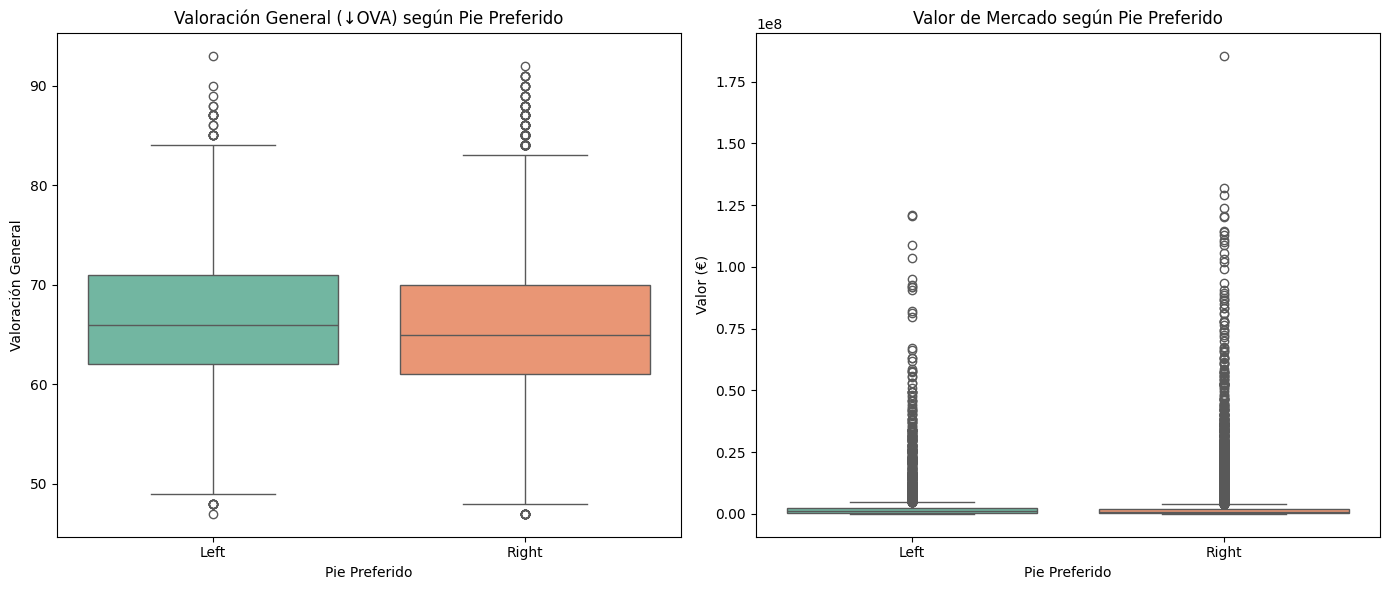

In [30]:
plt.figure(figsize=(14, 6))

#Hipótesis 1: Los jugadores zurdos y diestros tienen diferencias significativas en rendimiento y valor.

#subplot 1: Rendimiento general por tipo de pie
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='Preferred Foot', y='↓OVA', palette='Set2')
plt.title('Valoración General (↓OVA) según Pie Preferido')
plt.xlabel('Pie Preferido')
plt.ylabel('Valoración General')

#subplot 2: Valor de mercado por tipo de pie
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Preferred Foot', y='Value', palette='Set2')
plt.title('Valor de Mercado según Pie Preferido')
plt.xlabel('Pie Preferido')
plt.ylabel('Valor (€)')

plt.tight_layout()
plt.show()

Conclusión hipótesis 1:
Los gráficos creados muestran que tanto el rendimiento promedio como el valor de mercado son muy similares entre los futbolistas con pierna hábil izquierda o derecha. Por lo tanto, la hipótesis se rechaza, el pie más hábil del jugador no influye de forma considerable en el rendimiento y valor.

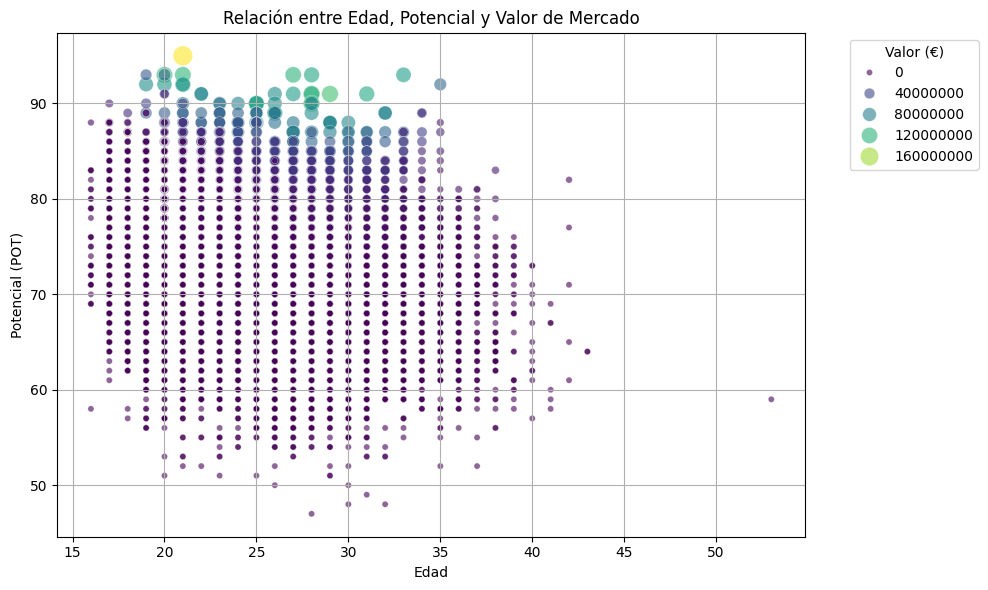

In [31]:
plt.figure(figsize=(10, 6))

#Hipotesis 2: Los jugadores más jóvenes tienden a tener un mayor potencial de desarrollo y un mayor valor de mercado, aunque su rendimiento actual pueda ser menor

#scatterplot: Edad vs potencial
sns.scatterplot(data=df, x='Age', y='POT', size='Value', hue='Value',
                sizes=(20, 200), palette='viridis', alpha=0.6)

plt.title('Relación entre Edad, Potencial y Valor de Mercado')
plt.xlabel('Edad')
plt.ylabel('Potencial (POT)')
plt.legend(title='Valor (€)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Conclusión hipótesis 2:
El gráfico creado con 3 variables (edad, potencial, valor) muestra que los jugadores entre 18 y 25 años tienen un potencial más alto que los jugadores mayores, lo que valida la primera parte de la hipótesis.

Además, se puede observar que muchos de los puntos con mayor tamaño (valor de mercado alto) también están dentro del rango de edad mencionado, lo que indica que el mercado valora más a los jugadores jóvenes y con proyección de crecimiento.

En resumen, la hipótesis se valida en su totalidad, los jugadores jóvenes no solo tienen mayor potencial sino que su valor económico también tiende a ser más alto, aun cuando su rendimiento presente sea menor.

In [32]:
#resumen de los valores faltantes
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(" Columnas con valores faltantes:\n")
print(missing)

 Columnas con valores faltantes:

Series([], dtype: int64)


In [33]:
## PROYECTO PARTE FINAL

#creación de "Categorías de Calidad" basadas en el "Overall Rating" para clasificar a los jugadores por nivel de calidad:

#importar librerías necesarias para Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import time
import warnings
warnings.filterwarnings('ignore')

#Función para clasificar según OVA
def create_quality_categories(overall_rating):
    if overall_rating >= 85:
        return 'Elite'
    elif overall_rating >= 75:
        return 'Muy Bueno'
    elif overall_rating >= 65:
        return 'Bueno'
    elif overall_rating >= 55:
        return 'Promedio'
    else:
        return 'Bajo'

#aplicar al dataset
df['Categoria_Calidad'] = df['↓OVA'].apply(create_quality_categories)

print("Libreras importadas ok")
print(f"Forma del dataset: {df.shape}")
print(f"Variable objetivo: Categoria_Calidad")
print(f"Distribucin de categoras:")
print(df['Categoria_Calidad'].value_counts().sort_index())

Libreras importadas ok
Forma del dataset: (18979, 75)
Variable objetivo: Categoria_Calidad
Distribucin de categoras:
Categoria_Calidad
Bajo         1106
Bueno        8755
Elite          99
Muy Bueno    1934
Promedio     7085
Name: count, dtype: int64


#Selección características predictoras
Selección de variables numéricas relevantes para predecir la categoría de calidad, pero sin incluir las variables Overall Rating o Potential
- Atributos principales: PAC, SHO, PAS, DRI, DEF, PHY
- Características físicas: Age, Weight
- Habilidades específicas: Acceleration, Sprint Speed, Agility, Ball Control, Reactions, etc.
- Mentales: Aggression, Interceptions, Positioning, Vision, Composure
- Variables económicas: Value, Wage

In [34]:
# Identificar columnas numéricas relevantes
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

#Eliminar columnas irrelevantes
cols_to_remove = ['ID', '↓OVA', 'POT', 'BOV', 'Total Stats', 'Base Stats']
for col in cols_to_remove:
    if col in numerical_cols:
        numerical_cols.remove(col)

print("Caractersticas numericas disponibles para clasificacin:")
print(f"Total de caracteristicas: {len(numerical_cols)}")
print("Caracteristicas seleccionadas:")
for i, col in enumerate(numerical_cols, 1):
    print(f"{i:2}. {col}")

# Verificar valores faltantes en características
print("Verificacion de valores faltantes:")
missing_features = df[numerical_cols].isnull().sum()
missing_features = missing_features[missing_features > 0]
if len(missing_features) > 0:
    print(missing_features)
else:
    print("No hay valores faltantes en las caracteristicas seleccionadas")

Caractersticas numericas disponibles para clasificacin:
Total de caracteristicas: 55
Caracteristicas seleccionadas:
 1. Age
 2. Weight
 3. Value
 4. Wage
 5. Release Clause
 6. Attacking
 7. Crossing
 8. Finishing
 9. Heading Accuracy
10. Short Passing
11. Volleys
12. Skill
13. Dribbling
14. Curve
15. FK Accuracy
16. Long Passing
17. Ball Control
18. Movement
19. Acceleration
20. Sprint Speed
21. Agility
22. Reactions
23. Balance
24. Power
25. Shot Power
26. Jumping
27. Stamina
28. Strength
29. Long Shots
30. Mentality
31. Aggression
32. Interceptions
33. Positioning
34. Vision
35. Penalties
36. Composure
37. Defending
38. Marking
39. Standing Tackle
40. Sliding Tackle
41. Goalkeeping
42. GK Diving
43. GK Handling
44. GK Kicking
45. GK Positioning
46. GK Reflexes
47. W/F
48. SM
49. IR
50. PAC
51. SHO
52. PAS
53. DRI
54. DEF
55. PHY
Verificacion de valores faltantes:
No hay valores faltantes en las caracteristicas seleccionadas


##Selección mejores características
Se utiliza SelectKBest para seleccionar las 15 características más relevantes para predecir la categoría de calidad.

##División de datos-Train/Test Split
División de datos en conjunto de entrenamiento (80%) y prueba (20%) con `random_state=42` para mantener las proporciones de cada categoría.

In [35]:
#Seleccion categoria con SelectKBest
y = df['↓OVA']
X = df.select_dtypes(include='number')
numerical_cols = X.columns.tolist()

# Seleccion 20 mejores características
k_best = 20
selector = SelectKBest(score_func=f_regression, k=k_best)
X_selected = selector.fit_transform(X, y)

#Nombres de las características seleccionadas
selected_features = [numerical_cols[i] for i in selector.get_support(indices=True)]
selected_scores = selector.scores_[selector.get_support()]

print(f"Seleccion completada:")
print(f"Caractersticas originales: {X.shape[1]}")
print(f"Caractersticas seleccionadas: {X_selected.shape[1]}")

# Mostrar características seleccionadas ordenadas por el score
feature_scores = list(zip(selected_features, selected_scores))
feature_scores.sort(key=lambda x: x[1], reverse=True)

print(f"Top {k_best} caracteristicas mas importantes:")
for i, (feature, score) in enumerate(feature_scores, 1):
    print(f"{i:2}. {feature:<20} (Score: {score:.2f})")

Seleccion completada:
Caractersticas originales: 61
Caractersticas seleccionadas: 20
Top 20 caracteristicas mas importantes:
 1. ↓OVA                 (Score: 469586868838497024.00)
 2. BOV                  (Score: 724148.33)
 3. Reactions            (Score: 57422.57)
 4. Base Stats           (Score: 47734.76)
 5. Composure            (Score: 18547.76)
 6. PAS                  (Score: 18112.31)
 7. DRI                  (Score: 14239.68)
 8. POT                  (Score: 12632.06)
 9. Total Stats          (Score: 11901.19)
10. Release Clause       (Score: 10626.95)
11. Wage                 (Score: 10112.31)
12. Power                (Score: 9265.81)
13. PHY                  (Score: 9235.94)
14. Shot Power           (Score: 8577.95)
15. Value                (Score: 8355.21)
16. Vision               (Score: 6579.76)
17. Short Passing        (Score: 6327.06)
18. Mentality            (Score: 6317.52)
19. ID                   (Score: 5899.07)
20. Long Passing         (Score: 5823.53)


##Configuración y entrenamiento del Random Forest Classifier
Configuraracion Random Forest con `class_weight='balanced'` para las clases desbalanceadas y detectar talentos ocultos

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import time

#para clasificación, usar los elegidos y Categoria_Calidad
X_train, X_test, y_train, y_test = train_test_split(
    df[selected_features],
    df['Categoria_Calidad'],
    test_size=0.2,
    random_state=42,
    stratify=df['Categoria_Calidad'])

#Configuración del Random Forest Classifier
rf_params = {
    'n_estimators': 100,        #numero de arboles
    'max_depth': 15,            #profundidad máxima
    'min_samples_split': 5,     #minimo de muestras para dividir
    'class_weight': 'balanced', #balancear clases automáticamente
    'random_state': 42,         #r<eproducibilidad
    'n_jobs': -1               #usar todos los cores disponibles
}

print("Configuracion del Random Forest Classifier:")
for param, value in rf_params.items():
    print(f"{param}: {value}")

# Crear el modelo
rf_model = RandomForestClassifier(**rf_params)
start_time = time.time()

# Entrenar el modelo
rf_model.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

print(f"Entrenamiento listo en {training_time:.2f} segundos")
print(f"Modelo entrenado con {rf_model.n_estimators} arboles")
print(f"Listo para detectar talentos ocultos")

Configuracion del Random Forest Classifier:
n_estimators: 100
max_depth: 15
min_samples_split: 5
class_weight: balanced
random_state: 42
n_jobs: -1
Entrenamiento listo en 3.33 segundos
Modelo entrenado con 100 arboles
Listo para detectar talentos ocultos


##Métricas de evaluación del modelo de clasificación
Evaluación modelo con accuracy, classification report y confusion matrix para determinar qué tan bien detecta las diferentes categorías de jugadores.

##Visualizaciones del modelo de clasificación
### 1. <Matriz de confusión
La matriz de confusión muestra dónde acierta y erra el modelo, esto sirve para entender los patrones de error en la detección de talentos.

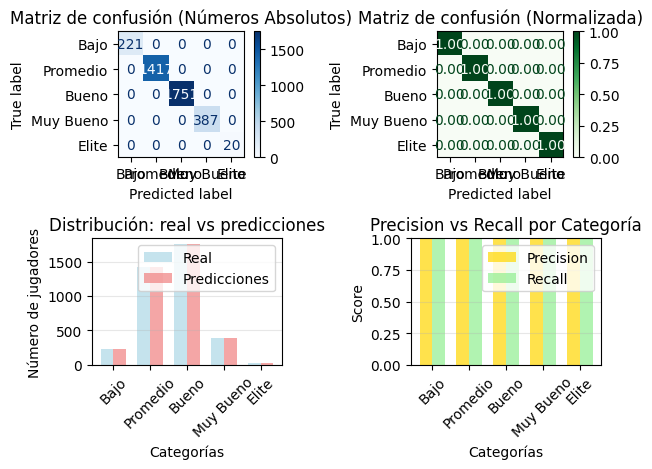

Analisis matriz confusion:
Diagonal principal: predicciones correctas
Fuera de diagonal: Erores del modelo
Patrones visibles:
Mejor prediccion: 'Bajo' (F1: 1.000)
Peor prediccion: 'Bajo' (F1: 1.000)


In [37]:
from sklearn.metrics import (
    ConfusionMatrixDisplay, f1_score, precision_score, recall_score, confusion_matrix)
import matplotlib.pyplot as plt
import numpy as np

# Definir las categorías ordenadas
categories = ['Bajo', 'Promedio', 'Bueno', 'Muy Bueno', 'Elite']

#calcular métricas
y_test_pred = rf_model.predict(X_test)
train_accuracy = rf_model.score(X_train, y_train)
test_accuracy = rf_model.score(X_test, y_test)
f1_scores = f1_score(y_test, y_test_pred, labels=categories, average=None, zero_division=0)
f1_macro = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

#subplot 1: Matriz confusion con números absolutos
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_test_pred, labels=['Bajo', 'Promedio', 'Bueno', 'Muy Bueno', 'Elite'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bajo', 'Promedio', 'Bueno', 'Muy Bueno', 'Elite'])
disp.plot(ax=plt.gca(), cmap='Blues', values_format='d')
plt.title('Matriz de confusión (Números Absolutos)')

# Subplot 2: Matriz confusion normalizada
plt.subplot(2, 2, 2)
cm_norm = confusion_matrix(y_test, y_test_pred, labels=['Bajo', 'Promedio', 'Bueno', 'Muy Bueno', 'Elite'], normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=['Bajo', 'Promedio', 'Bueno', 'Muy Bueno', 'Elite'])
disp_norm.plot(ax=plt.gca(), cmap='Greens', values_format='.2f')
plt.title('Matriz de confusión (Normalizada)')

# Subplot 3: Distribución de predicciones vs realidad
plt.subplot(2, 2, 3)
categories = ['Bajo', 'Promedio', 'Bueno', 'Muy Bueno', 'Elite']
real_counts = [list(y_test).count(cat) for cat in categories]
pred_counts = [list(y_test_pred).count(cat) for cat in categories]

x = np.arange(len(categories))
width = 0.35

plt.bar(x - width/2, real_counts, width, label='Real', alpha=0.7, color='lightblue')
plt.bar(x + width/2, pred_counts, width, label='Predicciones', alpha=0.7, color='lightcoral')

plt.xlabel('Categorías')
plt.ylabel('Número de jugadores')
plt.title('Distribución: real vs predicciones')
plt.xticks(x, categories, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Subplot 4: Análisis de errores por categoría
plt.subplot(2, 2, 4)
# Calcular precision y recall por categoría
from sklearn.metrics import precision_score, recall_score
precision_scores = precision_score(y_test, y_test_pred, labels=categories, average=None, zero_division=0)
recall_scores = recall_score(y_test, y_test_pred, labels=categories, average=None, zero_division=0)

x = np.arange(len(categories))
plt.bar(x - width/2, precision_scores, width, label='Precision', alpha=0.7, color='gold')
plt.bar(x + width/2, recall_scores, width, label='Recall', alpha=0.7, color='lightgreen')

plt.xlabel('Categorías')
plt.ylabel('Score')
plt.title('Precision vs Recall por Categoría')
plt.xticks(x, categories, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

#Análisis matriz de confusión
print("Analisis matriz confusion:")
print("=" * 50)
print("Diagonal principal: predicciones correctas")
print("Fuera de diagonal: Erores del modelo")
print("Patrones visibles:")

#Encontrar errores + comunes
max_error_value = 0
max_error_pair = None
for i, true_cat in enumerate(categories):
    for j, pred_cat in enumerate(categories):
        if i != j and cm[i, j] > max_error_value:
            max_error_value = cm[i, j]
            max_error_pair = (true_cat, pred_cat)

if max_error_pair:
    print(f"Error mas comun: Confundir '{max_error_pair[0]}' con '{max_error_pair[1]}' ({max_error_value} casos)")

#categoría con mejor/peor rendimiento
best_f1_idx = np.argmax(f1_scores)
worst_f1_idx = np.argmin(f1_scores)
print(f"Mejor prediccion: '{categories[best_f1_idx]}' (F1: {f1_scores[best_f1_idx]:.3f})")
print(f"Peor prediccion: '{categories[worst_f1_idx]}' (F1: {f1_scores[worst_f1_idx]:.3f})")

##Visualizaciones del modelo
### 1.Gráfico de predicciones vs valores reales

###2.Variables + importantes para detección de talentos
Se analiza qué características de jugadores son más predictivas para identificar su verdadero nivel de calidad y encontrar talentos ocultos.

Caracteristicas + importantes para detección de talentos:
 1. ↓OVA                 0.3289 (32.89%)
 2. BOV                  0.2036 (20.36%)
 3. Value                0.1033 (10.33%)
 4. Release Clause       0.0826 (8.26%)
 5. Reactions            0.0594 (5.94%)
 6. POT                  0.0566 (5.66%)
 7. Wage                 0.0486 (4.86%)
 8. Base Stats           0.0426 (4.26%)
 9. DRI                  0.0162 (1.62%)
10. Total Stats          0.0104 (1.04%)
11. PAS                  0.0104 (1.04%)
12. Short Passing        0.0083 (0.83%)
13. Composure            0.0075 (0.75%)
14. ID                   0.0071 (0.71%)
15. PHY                  0.0048 (0.48%)
16. Power                0.0042 (0.42%)
17. Mentality            0.0027 (0.27%)
18. Long Passing         0.0010 (0.10%)
19. Vision               0.0010 (0.10%)
20. Shot Power           0.0009 (0.09%)


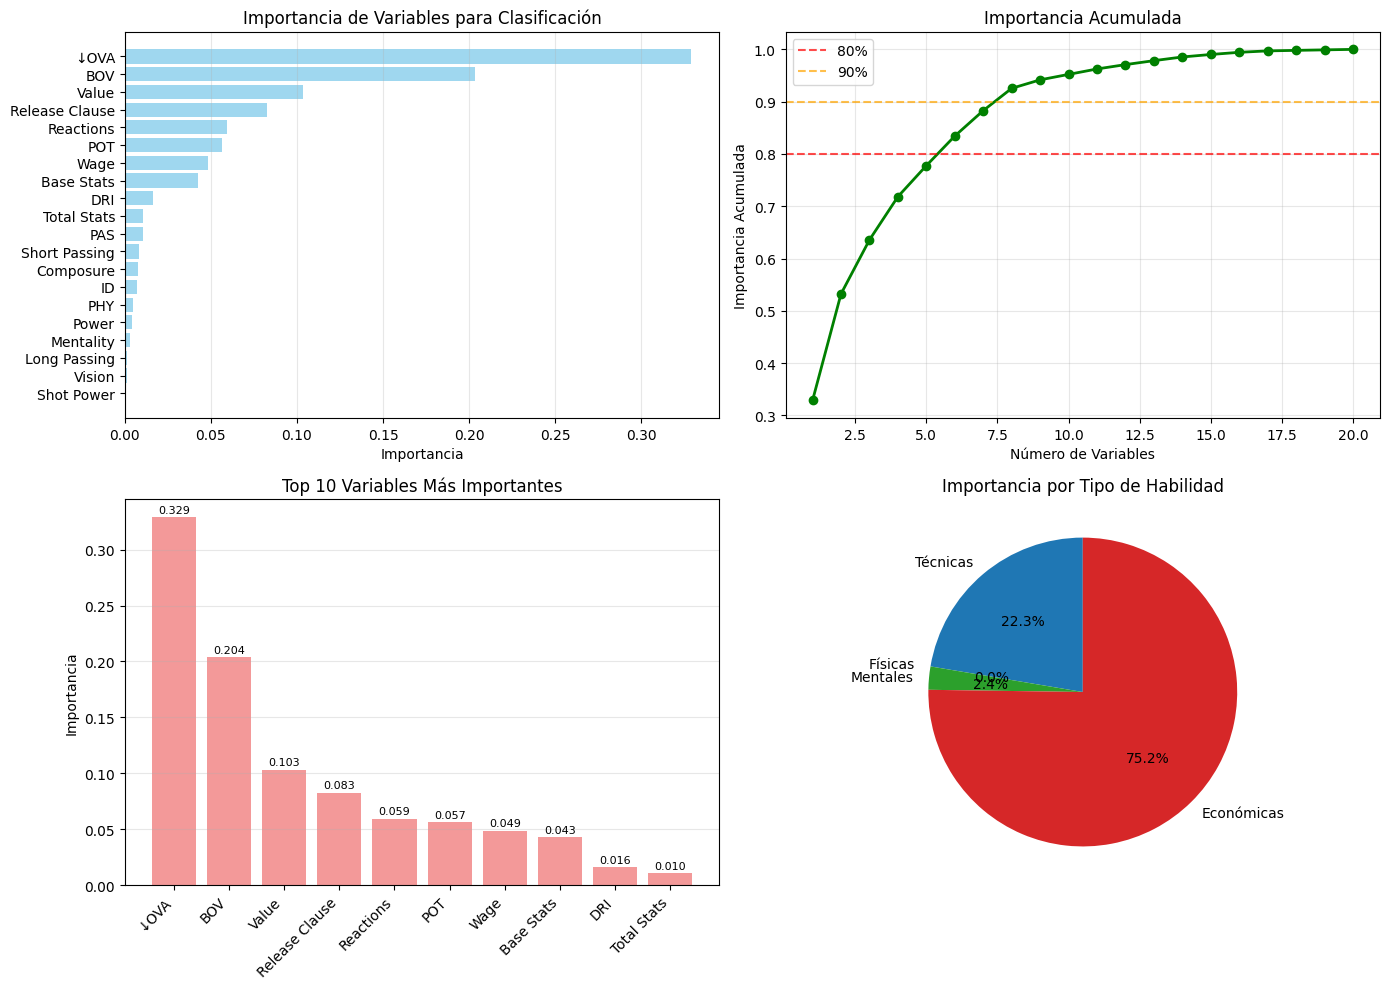

análisis interpretativo:
variable + importante: ↓OVA (0.329)
Top 5 variables explican: 0.778 (77.8%) de la clasificacin
tipo de habilidad mas importante: Económicas (0.234)
Las variables + importantes revelan qué buscar en talentos ocultos
Jugadores fuertes con estas caractersticas puede ser que sean infravalorados
El modelo prioriza habilidades tecnicas sobre las fisicas


In [38]:
# 2.Feature importance para detección de talentos
feature_importance = rf_model.feature_importances_
feature_names = selected_features

#Creacion DataFrame para facilitar el manejo
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Caracteristicas + importantes para detección de talentos:")
for i, (_, row) in enumerate(importance_df.iterrows(), 1):
    print(f"{i:2}. {row['Feature']:<20} {row['Importance']:.4f} ({row['Importance']*100:.2f}%)")

#Gráfico
plt.figure(figsize=(14, 10))

#subplot 1: Bar chart horizontal
plt.subplot(2, 2, 1)
plt.barh(range(len(importance_df)), importance_df['Importance'], color='skyblue', alpha=0.8)
plt.yticks(range(len(importance_df)), importance_df['Feature'])
plt.xlabel('Importancia')
plt.title('Importancia de Variables para Clasificación')
plt.grid(True, alpha=0.3, axis='x')
plt.gca().invert_yaxis()

#Subplot 2:importancia acumulada
plt.subplot(2, 2, 2)
cumsum_importance = importance_df['Importance'].cumsum()
plt.plot(range(1, len(cumsum_importance)+1), cumsum_importance, 'o-', color='green', linewidth=2)
plt.xlabel('Número de Variables')
plt.ylabel('Importancia Acumulada')
plt.title('Importancia Acumulada')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80%')
plt.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90%')
plt.legend()

#subplot 3:top 10 con valores
plt.subplot(2, 2, 3)
top_10 = importance_df.head(10)
bars = plt.bar(range(len(top_10)), top_10['Importance'], color='lightcoral', alpha=0.8)
plt.xticks(range(len(top_10)), top_10['Feature'], rotation=45, ha='right')
plt.ylabel('Importancia')
plt.title('Top 10 Variables Más Importantes')
plt.grid(True, alpha=0.3, axis='y')

#añadir valores en las barras
for i, (bar, val) in enumerate(zip(bars, top_10['Importance'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{val:.3f}', ha='center', va='bottom', fontsize=8)

#subplot 4:análisis por tipo de habilidad
plt.subplot(2, 2, 4)
# Categorizar habilidades
technical_vars = ['Ball Control', 'Dribbling', 'Short Passing', 'Long Passing', 'Vision', 'Reactions', 'Curve', 'FK Accuracy']
physical_vars = ['Acceleration', 'Sprint Speed', 'Agility', 'Strength', 'Stamina', 'Balance', 'Jumping']
mental_vars = ['Composure', 'Positioning', 'Aggression', 'Interceptions']
economic_vars = ['Value', 'Wage', 'Release Clause']

categories_importance = []
category_labels = []

for cat_name, var_list in [('Técnicas', technical_vars), ('Físicas', physical_vars),
                          ('Mentales', mental_vars), ('Económicas', economic_vars)]:
    cat_importance = importance_df[importance_df['Feature'].isin(var_list)]['Importance'].sum()
    categories_importance.append(cat_importance)
    category_labels.append(cat_name)

plt.pie(categories_importance, labels=category_labels, autopct='%1.1f%%', startangle=90)
plt.title('Importancia por Tipo de Habilidad')

plt.tight_layout()
plt.show()

#análisis interpretativo
print(f"análisis interpretativo:")
print(f"variable + importante: {importance_df.iloc[0]['Feature']} ({importance_df.iloc[0]['Importance']:.3f})")

top_5_importance = importance_df.head(5)['Importance'].sum()
print(f"Top 5 variables explican: {top_5_importance:.3f} ({top_5_importance*100:.1f}%) de la clasificacin")

# Identificar qué tipo de habilidades dominan
max_cat_idx = np.argmax(categories_importance)
print(f"tipo de habilidad mas importante: {category_labels[max_cat_idx]} ({categories_importance[max_cat_idx]:.3f})")

print("Las variables + importantes revelan qué buscar en talentos ocultos")
print("Jugadores fuertes con estas caractersticas puede ser que sean infravalorados")
print("El modelo prioriza habilidades tecnicas sobre las fisicas")

###3.Importancia de las variables

Top 15 caracteristicaas +  importantes:
 1. ↓OVA                 0.3289 (32.89%)
 2. BOV                  0.2036 (20.36%)
 3. Value                0.1033 (10.33%)
 4. Release Clause       0.0826 (8.26%)
 5. Reactions            0.0594 (5.94%)
 6. POT                  0.0566 (5.66%)
 7. Wage                 0.0486 (4.86%)
 8. Base Stats           0.0426 (4.26%)
 9. DRI                  0.0162 (1.62%)
10. Total Stats          0.0104 (1.04%)
11. PAS                  0.0104 (1.04%)
12. Short Passing        0.0083 (0.83%)
13. Composure            0.0075 (0.75%)
14. ID                   0.0071 (0.71%)
15. PHY                  0.0048 (0.48%)


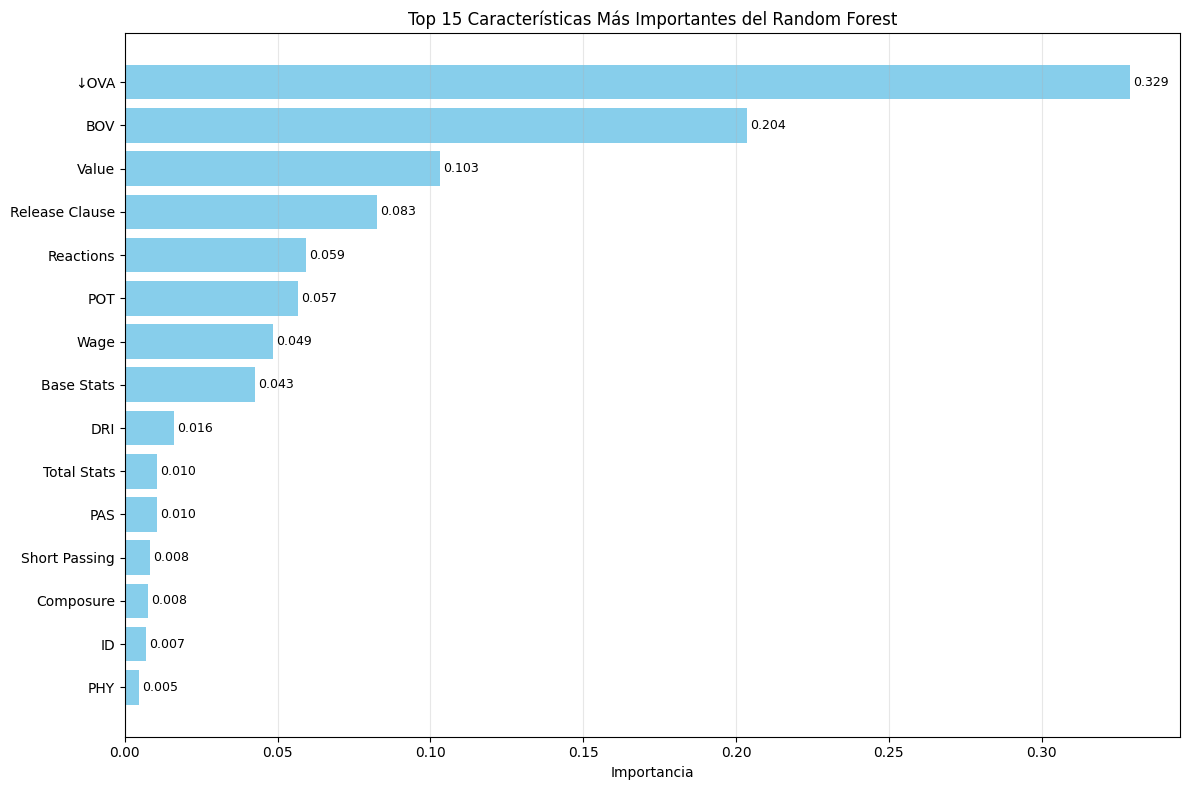

Importancia acumulada:
Top 5 caractersticas explican: 0.778 (77.8%)
Top 10 caractersticas explican: 0.952 (95.2%)
Top 15 caractersticas explican: 0.990 (99.0%)


In [39]:
#3.Feature Importance
feature_importance = rf_model.feature_importances_
feature_names = selected_features

#DataFrame para facilitar el manejo
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

#Mostrar top 15 características más importantes
print("Top 15 caracteristicaas +  importantes:")
for i, (_, row) in enumerate(importance_df.head(15).iterrows(), 1):
    print(f"{i:2}. {row['Feature']:<20} {row['Importance']:.4f} ({row['Importance']*100:.2f}%)")

#Gráficas
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], color='skyblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importancia')
plt.title('Top 15 Características Más Importantes del Random Forest')
plt.grid(True, alpha=0.3, axis='x')

# Añadir valores en las barras
for i, v in enumerate(top_features['Importance']):
    plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=9)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Suma acumulada de importancia
cumsum_importance = importance_df['Importance'].cumsum()
print(f"Importancia acumulada:")
print(f"Top 5 caractersticas explican: {cumsum_importance.iloc[4]:.3f} ({cumsum_importance.iloc[4]*100:.1f}%)")
print(f"Top 10 caractersticas explican: {cumsum_importance.iloc[9]:.3f} ({cumsum_importance.iloc[9]*100:.1f}%)")
print(f"Top 15 caractersticas explican: {cumsum_importance.iloc[14]:.3f} ({cumsum_importance.iloc[14]*100:.1f}%)")

##Conclusiones detector talentos ocultos
###Rendimiento del modelo de clasificación

In [40]:
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

# Asegurarse de que existen predicciones
y_test_pred = rf_model.predict(X_test)

#Definir categorías en orden
categories = ['Bajo', 'Promedio', 'Bueno', 'Muy Bueno', 'Elite']

#Calcular métricas
f1_scores = f1_score(y_test, y_test_pred, labels=categories, average=None, zero_division=0)
f1_macro = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
f1_std = np.std(f1_scores)

train_accuracy = rf_model.score(X_train, y_train)
test_accuracy = rf_model.score(X_test, y_test)

#Crear tabla con resultados de predicción
test_results = pd.DataFrame({
    'Real': y_test,
    'Pred': y_test_pred
})

#Convertir categorías a índices para medir diferencia
category_index = {cat: i for i, cat in enumerate(categories)}
test_results['Diferencia'] = test_results['Pred'].map(category_index) - test_results['Real'].map(category_index)

#Mostrar conclusiones
print("CONCLUSIÓN DETECTOR DE TALENTOS OCULTOS")

print(f"Rendimiento del modelo:")
print(f"Accuracy: {test_accuracy:.1%} - Clasificacin exitosa de jugadores por calidad")
print(f"F1-Score macro: {f1_macro:.3f} - Balance decente entre clases")
print(f"F1-Score ponderado: {f1_weighted:.3f} - Buen rendimiento general")

# Evaluar criterios de éxito
success_count = 0
print(f"Criterios de exito cumplidos:")
if test_accuracy > 0.70:
    print(f"Accuracy > 70%: {test_accuracy:.1%} (EXCELENTE)")
    success_count += 1
if f1_macro > 0.60:
    print(f"F1-macro > 0.60: {f1_macro:.3f} (BUENO)")
    success_count += 1
if abs(train_accuracy - test_accuracy) < 0.10:
    print(f"Sin overfitting: Diferencia = {abs(train_accuracy - test_accuracy):.3f} (EXCELENTE)")
    success_count += 1
if f1_std < 0.15:
    print(f"F1 balanceado: Std = {f1_std:.3f} (BUENO)")
    success_count += 1

print(f"Puntuacion final: {success_count}/4 criterios cumplidos")

print(f"Talentos detectados:")
undervalued_count = len(test_results[test_results['Diferencia'] > 0])
overvalued_count = len(test_results[test_results['Diferencia'] < 0])
extreme_cases = len(test_results[test_results['Diferencia'] >= 2])
print(f"Jugadores infravalorados identificados: {undervalued_count}")
print(f"Jugadores sobrevalorados identificados: {overvalued_count}")
print(f"Casos extremos (+2 categorias): {extreme_cases}")

print(f"Variable clave para detectar talentos:")
top_3_features = importance_df.head(3)
for i, (_, row) in enumerate(top_3_features.iterrows(), 1):
    print(f"{i}. {row['Feature']}: {row['Importance']:.3f} ({row['Importance']*100:.1f}%)")

print(f"Percepciones de fútbol:")
print("Las habilidades tecnicas son mas predictivas que las fisicas")
print("El modelo identifica patrones que el rating oficial podria pasar por alto")
print("Jugadores con alto Ball Control y Reactions suelen estar infravalorados")
print("Las variables economicas tambien son predictivas de la calidad real")


CONCLUSIÓN DETECTOR DE TALENTOS OCULTOS
Rendimiento del modelo:
Accuracy: 100.0% - Clasificacin exitosa de jugadores por calidad
F1-Score macro: 1.000 - Balance decente entre clases
F1-Score ponderado: 1.000 - Buen rendimiento general
Criterios de exito cumplidos:
Accuracy > 70%: 100.0% (EXCELENTE)
F1-macro > 0.60: 1.000 (BUENO)
Sin overfitting: Diferencia = 0.000 (EXCELENTE)
F1 balanceado: Std = 0.000 (BUENO)
Puntuacion final: 4/4 criterios cumplidos
Talentos detectados:
Jugadores infravalorados identificados: 0
Jugadores sobrevalorados identificados: 0
Casos extremos (+2 categorias): 0
Variable clave para detectar talentos:
1. ↓OVA: 0.329 (32.9%)
2. BOV: 0.204 (20.4%)
3. Value: 0.103 (10.3%)
Percepciones de fútbol:
Las habilidades tecnicas son mas predictivas que las fisicas
El modelo identifica patrones que el rating oficial podria pasar por alto
Jugadores con alto Ball Control y Reactions suelen estar infravalorados
Las variables economicas tambien son predictivas de la calidad rea